# Exercise 10: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository. 

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?). 

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data. 

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [4]:
# WRITE YOUR CODE HERE
library(tidyverse)

# read in lexDat and item files
lexDat <- read.csv('LexicalData_withIncorrect.csv')
items <- read.csv('Items.csv')

# select variables of interest in items and set key for left_join()
items_subset <- items%>%
  select(Word,Length, Log_Freq_HAL) %>%
  rename(D_Word = Word)

# join datasets together & remove NAs
lexDat_joined <- lexDat %>%
 left_join(items_subset, by = 'D_Word') %>%
 drop_na() # remove NA values

head(lexDat_joined)

,X,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Length,Log_Freq_HAL
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
1,1,157,1,1,710,browse,false,-0.437,1,6,8.856
2,2,67,1,1,"1,094",refrigerant,false,0.825,1,11,4.644
3,3,120,1,1,587,gaining,false,-0.645,1,7,8.304
4,4,21,1,1,984,cheerless,false,0.025,1,9,2.639
5,5,236,1,1,577,pattered,false,-0.763,1,8,1.386
6,6,236,2,1,715,conjures,false,-0.364,1,8,5.268


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

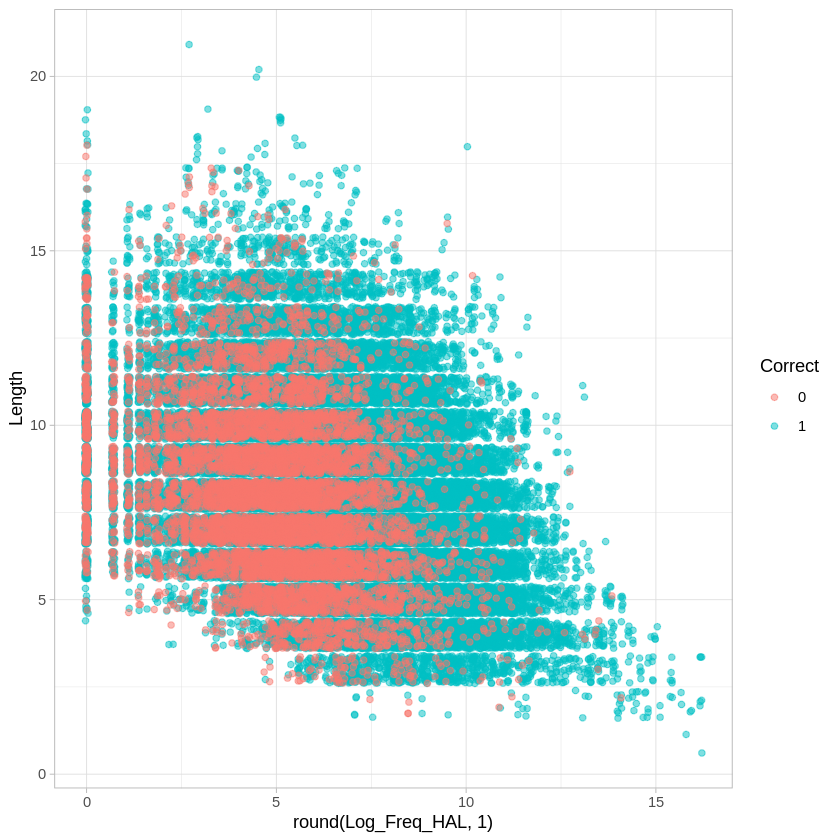

In [8]:
require(tidyverse) # Load the tidyverse package, if you haven't yet
lexDat_joined$Correct <- as.factor(lexDat_joined$Correct) # so that R knows that Correct is categorical, not numeric. 

# plot the Correct / Incorrect clusters
ggplot(lexDat_joined,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light() 

What do you observe about the "Correct" and "Incorrect" clusters? 

> The majority of the "Incorrect" cluster is fully contained within the "Correct" cluster. A linear decision boundary is unlikely to succesfully classify correct and incorrect choices. It also appears to be the case that there is a serious class imbalance in favor of 'correct' decisions, based on the proportions of blue vs red dots.

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [10]:
# WRITE YOUR CODE HERE
logreg_mdl <- glm(Correct ~ Length * Log_Freq_HAL, data=lexDat_joined, family=binomial)
summary(logreg_mdl)


Call:
glm(formula = Correct ~ Length * Log_Freq_HAL, family = binomial, 
    data = lexDat_joined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0494   0.3178   0.4182   0.5208   1.3225  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> Based on the results of the fitted logistic regression model, we can see that both word length and Log_Freq_HAL as well as their interaction term are associated with whether a lexical decision is correct or incorrect. 

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

In [40]:
# WRITE YOUR CODE HERE
glm_prob_df <- data.frame(predict(logreg_mdl, type = "response")) # get continuous predictions
colnames(glm_prob_df) = c('predicted_prob') # rename column
num_observations = nrow(glm_prob_df) # get num_obs for binarizing

# Threshold and binarize predictions
threshold <- 0.5
glm_prob_df$predicted_binary <- rep(0,num_observations)
glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>threshold] = 1 

# Confusion Matrix
confusion_df <- data.frame(glm_prob_df$predicted_binary, lexDat_joined$Correct)
colnames(confusion_df) <- c('predicted', 'actual')
table(confusion_df)
print(paste("Accuracy:",mean(glm_prob_df$predicted_binary==lexDat_joined$Correct)))


         actual
predicted     0     1
        0    13    44
        1  7966 62566

[1] "Accuracy: 0.886526229299183"


Did the model do well at predicting lexical decision correctness? Why or why not? 

> While the logistic regression classifier reaches approximately 89% accuracy on predicting lexical decision correctness, the model overwhelmingly predicts 'correct' decisions regardless of the actual decision value. This can be visualized in the confusion matrix, where the majority of true 'incorrect' answers are classified as 'correct'. This is the result of class imbalance, as there are far more 'correct' decisions than 'incorrect' in the data.

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`. 

*Hint: see the Classifiers tutorial.*

In [30]:
# WRITE YOUR CODE HERE
library(MASS)

qda_mdl <- qda(Correct ~ Length * Log_Freq_HAL, data=lexDat_joined)
qda_mdl

Call:
qda(Correct ~ Length * Log_Freq_HAL, data = lexDat_joined)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL Length:Log_Freq_HAL
0 8.047124     4.932123            37.95260
1 7.979971     6.444849            49.34219

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy. 

In [36]:
# WRITE YOUR CODE HERE

# predict based on fitted QDA model
qda.class <- predict(qda_mdl, lexDat_joined)$class

# Confusion Matrix
table(qda.class, lexDat_joined$Correct)
print(paste("Accuracy:",mean(qda.class==lexDat_joined$Correct)))

         
qda.class     0     1
        0   455  1647
        1  7524 60963

[1] "Accuracy: 0.870078907478502"


How does QDA prediction performance differ from that of logistic regression?

> While the QDA model results in very similar classification accuracy to the logistic regression classifier, one can observe from the confusion matrix that QDA is less susceptible to the class imbalance problem than the logistic regression classifier. 

**DUE:** 5pm EST, March 20, 2023

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*